# Лабораторна робота 4
## Знайомство з нейромережами і Keras
### Щербакова Валерія, ФІ-71
Part 1 dataset: https://www.kaggle.com/jacobbaruch/basketball-players-stats-per-season-49-leagues
Part 2 dataset: https://www.kaggle.com/chetankv/dogs-cats-images
Part 3 dataset: NLTK Brown Corpus (https://www.nltk.org/book/ch02.html#tab-brown-sources)

In [126]:
import os, matplotlib.pyplot as plt, numpy as np, nltk, itertools
from pandas import read_csv
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_visualizer import visualizer
from IPython.display import Image
from sklearn.metrics import confusion_matrix
from nltk.corpus import brown, stopwords
from tensorflow.keras.preprocessing.text import Tokenizer

# Part 1: Data classification (fully connected FFN)
Вирішіть завдання класифікації даних, з якими ви працювали в лабораторній No 2 за допомогою
повнозв’язаної нейромережі прямого поширення (fully connected feed-forward network)

Використовуємо дані та класифікацію з 2-3 Л/Р.

In [2]:
data = read_csv(r'players_stats_by_season_full_details.csv')
adata = data[['GP','MIN','FGM','FGA','3PM','3PA','FTM','FTA','TOV','PF','ORB','DRB','REB','AST','STL','BLK','PTS']]

def classify(row):
    crit = row['PTS']
    if crit < 200: return 0
    if crit < 400: return 1
    if crit < 800: return 2
    if crit < 1600: return 3
    return 4

data_Y = adata.apply(lambda row: classify(row), axis=1)
tens_Y = to_categorical(data_Y)
data_X = adata.drop(['PTS', 'FGA', 'FGM'], axis=1)  # drop if correlation >= 0.99

train_X, test_X, train_Y, test_Y = train_test_split(data_X, tens_Y, test_size=0.3, random_state=2021_12_27)

Побудова та візуалізація моделі.

In [3]:
model = Sequential()

model.add(Dense(14, input_shape=(14,), activation="sigmoid"))
model.add(Dense(75, activation="relu"))
model.add(Dense(50, activation="relu"))
model.add(Dense(25, activation="relu"))
model.add(Dense(5, activation='softmax'))
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=[BinaryAccuracy(name='acc'), Precision(name='prc'), Recall(name='rec')])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                210       
                                                                 
 dense_1 (Dense)             (None, 75)                1125      
                                                                 
 dense_2 (Dense)             (None, 50)                3800      
                                                                 
 dense_3 (Dense)             (None, 25)                1275      
                                                                 
 dense_4 (Dense)             (None, 5)                 130       
                                                                 
Total params: 6,540
Trainable params: 6,540
Non-trainable params: 0
_________________________________________________________________


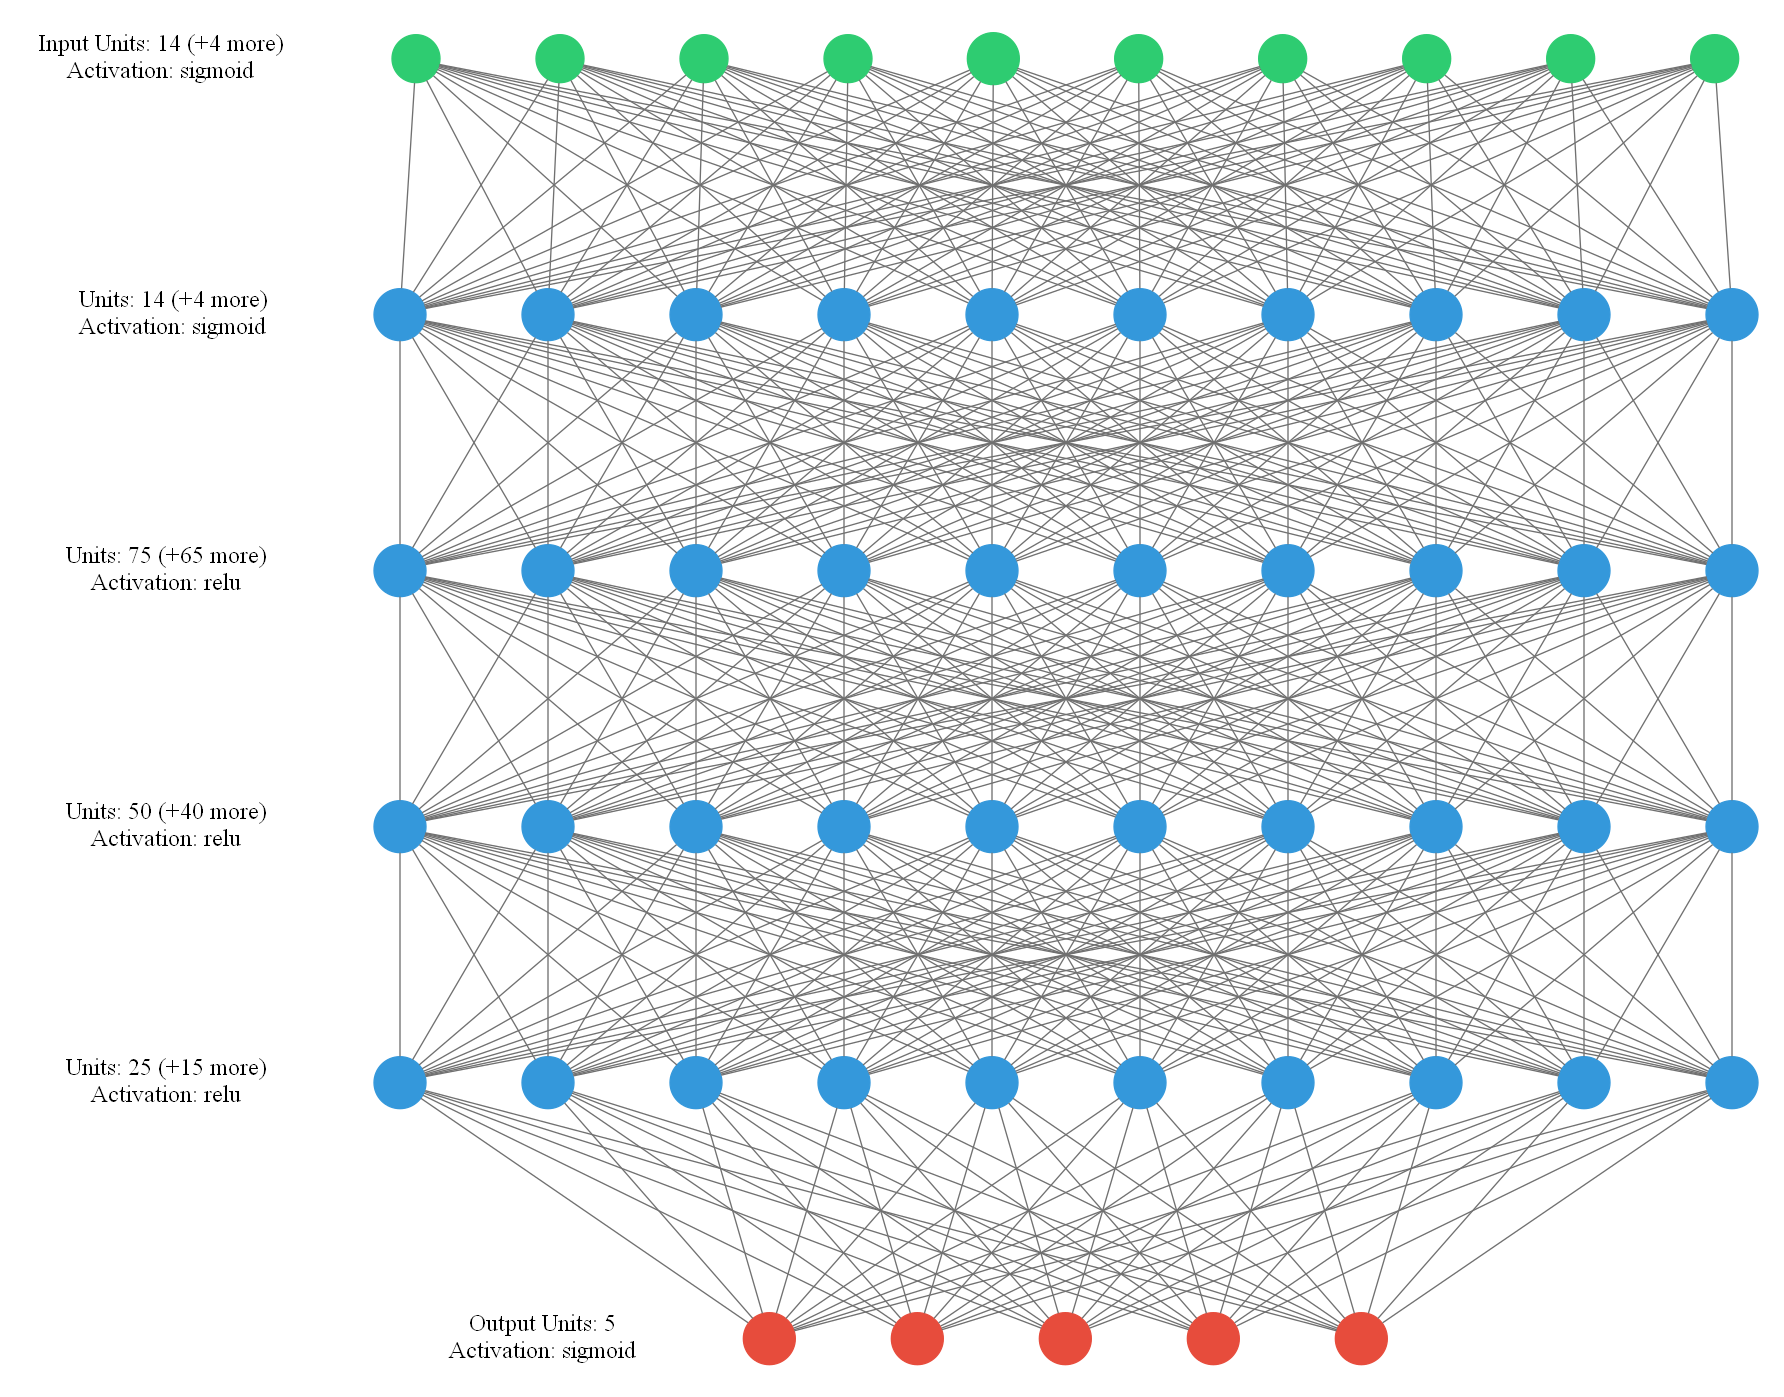

In [4]:
visualizer(model, format='png', filename='model')
Image(filename='model.png')

Навчання моделі на тренувальних даних з одночасною валідацією на тестових.

In [6]:
history = model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=50, batch_size=256)

Epoch 1/50
148/148 [==============================] - 1s 8ms/step - loss: 0.9631 - acc: 0.8395 - prc: 0.6982 - rec: 0.3483 - val_loss: 0.9471 - val_acc: 0.8419 - val_prc: 0.7572 - val_rec: 0.3087
Epoch 2/50
148/148 [==============================] - 1s 8ms/step - loss: 0.9338 - acc: 0.8424 - prc: 0.7056 - rec: 0.3641 - val_loss: 0.9220 - val_acc: 0.8428 - val_prc: 0.7126 - val_rec: 0.3585
Epoch 3/50
148/148 [==============================] - 1s 6ms/step - loss: 0.9034 - acc: 0.8462 - prc: 0.7078 - rec: 0.3935 - val_loss: 0.8892 - val_acc: 0.8489 - val_prc: 0.7023 - val_rec: 0.4243
Epoch 4/50
148/148 [==============================] - 1s 7ms/step - loss: 0.8762 - acc: 0.8496 - prc: 0.7048 - rec: 0.4266 - val_loss: 0.8662 - val_acc: 0.8520 - val_prc: 0.7265 - val_rec: 0.4171
Epoch 5/50
148/148 [==============================] - 1s 7ms/step - loss: 0.8557 - acc: 0.8527 - prc: 0.6984 - rec: 0.4638 - val_loss: 0.8398 - val_acc: 0.8558 - val_prc: 0.6822 - val_rec: 0.5228
Epoch 6/50
148/148 [

Зміна метрик моделі на тренувальних та тестових даних в процесі навчання.

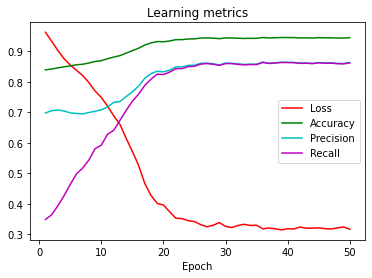

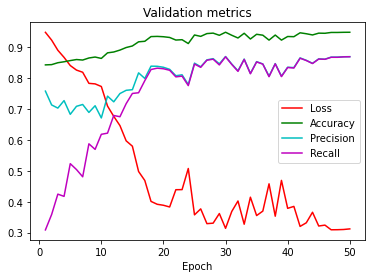

In [7]:
hist = history.history
x = range(1, len(hist['loss']) + 1)

plt.plot(x, hist['loss'], 'r', label='Loss')
plt.plot(x, hist['acc'], 'g', label='Accuracy')
plt.plot(x, hist['prc'], 'c', label='Precision')
plt.plot(x, hist['rec'], 'm', label='Recall')
plt.title('Learning metrics')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(x, hist['val_loss'], 'r', label='Loss')
plt.plot(x, hist['val_acc'], 'g', label='Accuracy')
plt.plot(x, hist['val_prc'], 'c', label='Precision')
plt.plot(x, hist['val_rec'], 'm', label='Recall')
plt.title('Validation metrics')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Виведення профілю впевненості по даним, тобто різницю між ймовірністю коректного класу та найбільшою ймовірністю некоректного класу. Показує наскільки коректно та впевнено класифікуються дані. Значення менше 0 - некоректна класифікація, більше 0 - коректна.

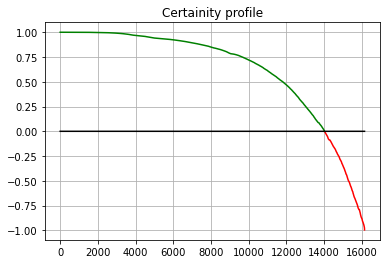

Correct prediction in 14015 / 16140 samples
Mistaken by 1 classes: 2122
Mistaken by 2 classes: 3

Confusion matrix (binary - select by max probability):


array([[6027,  422,    1,    0,    0],
       [ 522, 4645,  492,    2,    0],
       [   0,  348, 2691,  168,    0],
       [   0,    0,   71,  651,    0],
       [   0,    0,    0,   99,    1]], dtype=int64)

In [8]:
pred_X = model.predict(test_X)
pred_cls = []
test_cls = []

x = range(0, len(pred_X))
prob_delt = []
cls_dist = []
good_cnt = 0
for i in x:
    pred = pred_X[i]
    test = test_Y[i]
    pred_cls.append(np.argmax(pred))
    test_cls.append(np.argmax(test))
    prob = np.max(pred * test)
    badp = np.max(pred * (1 - test))
    prob_delt.append(prob - badp)
    if prob - badp > 0:
        good_cnt += 1
    else:
        cls_dist.append(abs(np.argmax(test) - np.argmax(pred * (1 - test))))

prob_delt.sort(reverse=True)

plt.plot(x, [(i if i < 0 else np.nan) for i in prob_delt], 'r')
plt.plot(x, [(i if i >= 0 else np.nan) for i in prob_delt], 'g')
plt.plot(x, np.zeros(len(x)), 'k')
plt.title('Certainity profile')
plt.grid()
plt.show()

print('Correct prediction in ' + str(good_cnt) + ' / ' + str(len(pred_X)) + ' samples')
for i in range(1, 5):
    mist = sum([1 if j == i else 0 for j in cls_dist])
    if mist > 0:
        print('Mistaken by ' + str(i) + ' classes: ' + str(mist))
print('')
print('Confusion matrix (binary - select by max probability):')
confusion_matrix(test_cls, pred_cls)

# Part 2: Image classification (convolutional NN)
Вирішіть завдання класифікації зображень за допомогою згорткової (convolutional) нейромережі
(якщо в обраному датасеті класів забагато, достатньо залишити 3-5).

Я взяла котиків і собачок, тобто 2 класи.

In [10]:
train_dir = 'dataset/training_set'
test_dir = 'dataset/test_set'

data_generator_train = ImageDataGenerator(rescale = 1.0/255.0, zoom_range = 0.2, rotation_range = 15)
data_generator_test = ImageDataGenerator(rescale = 1.0/255.0)

target_size = (64, 64)
batch_size = 32

train_data = data_generator_train.flow_from_directory(train_dir, target_size, batch_size=batch_size, class_mode='binary')
test_data = data_generator_test.flow_from_directory(test_dir, target_size, batch_size=batch_size, class_mode='binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [11]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = train_data.image_shape))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.3))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))
model.add(Conv2D(filters = 126, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.15))
model.add(Flatten())
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dropout(rate = 0.15))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.1))
model.add(Dense(units = len(set(train_data.classes)), activation = 'softmax'))
model.summary()
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 14, 14, 64)       

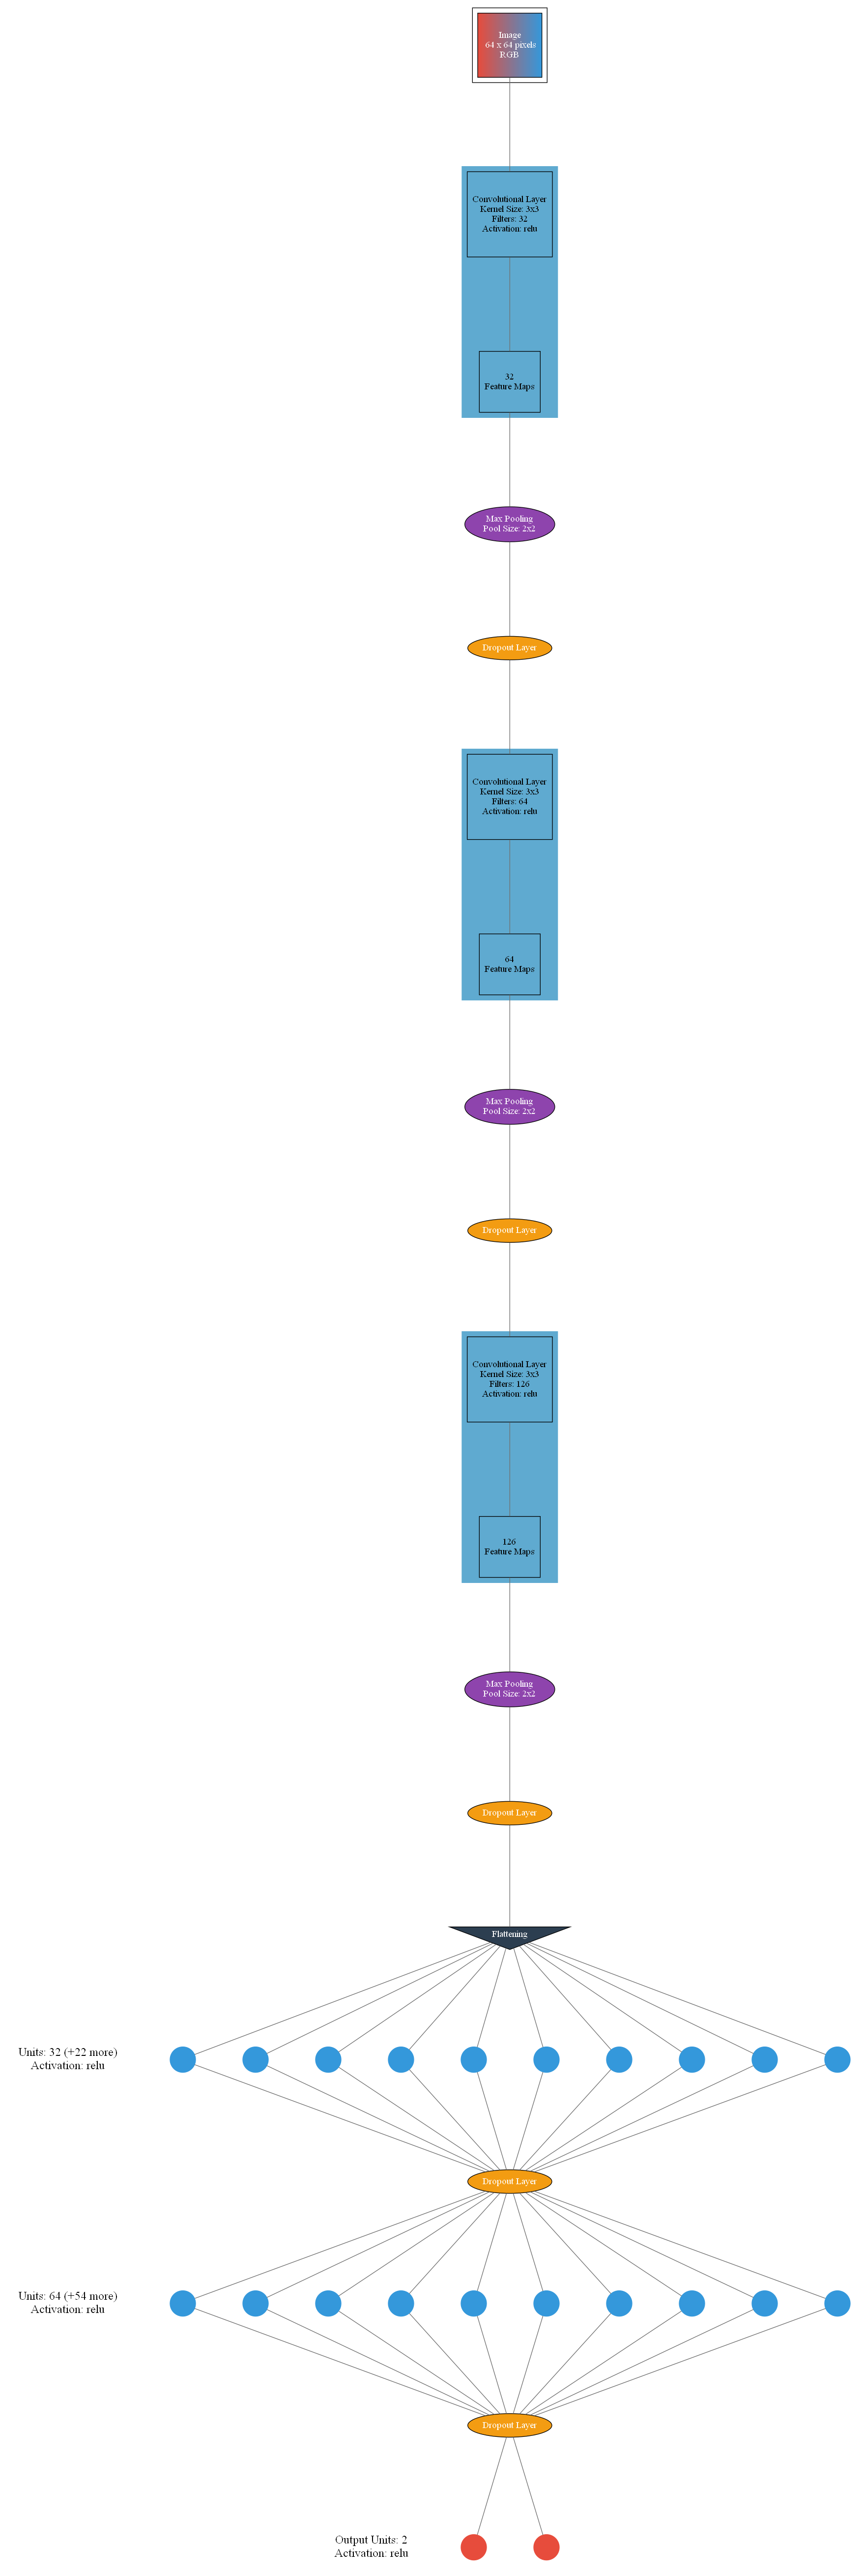

In [12]:
visualizer(model, format='png', filename='model2')
Image(filename='model2.png')

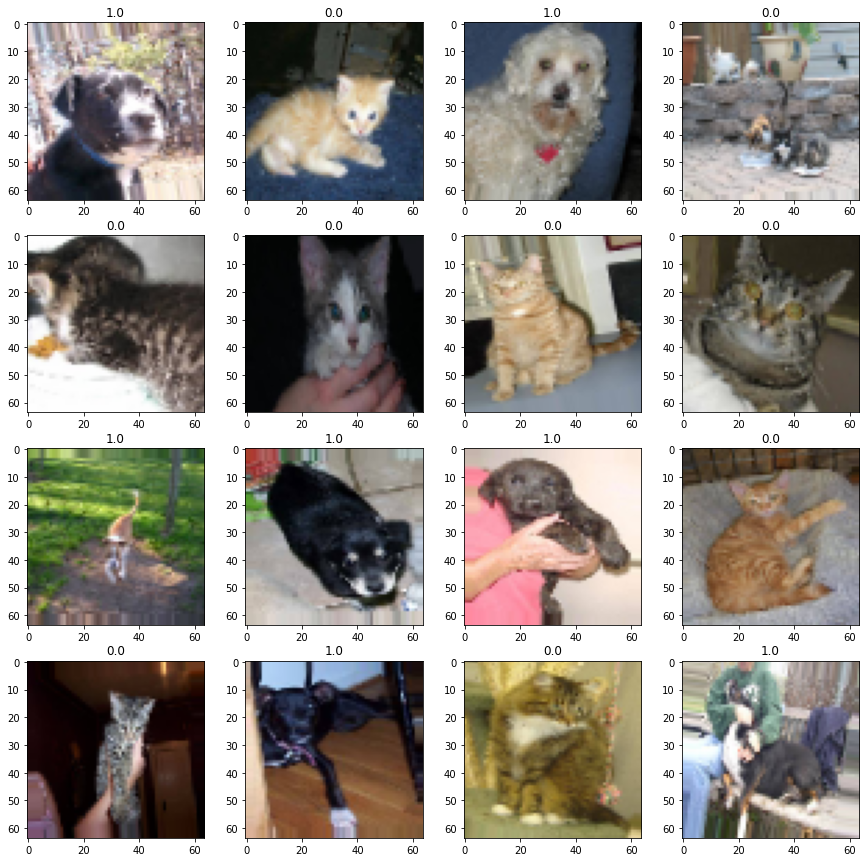

In [85]:
sample = train_data.next()

fig, axs = plt.subplots(4, 4)
fig.set_size_inches(15,15)

idx = 0

for y in range(0, 4):
    for x in range(0, 4):
        ax = axs[x,y]
        ax.set_title(sample[1][idx])
        ax.imshow(sample[0][idx])
        idx += 1

In [13]:
history = model.fit(train_data, epochs=100, validation_data=test_data)

Epoch 1/100
250/250 [==============================] - 19s 73ms/step - loss: 0.6937 - accuracy: 0.5077 - val_loss: 0.6907 - val_accuracy: 0.5435
Epoch 2/100
250/250 [==============================] - 18s 72ms/step - loss: 0.6769 - accuracy: 0.5727 - val_loss: 0.6645 - val_accuracy: 0.5735
Epoch 3/100
250/250 [==============================] - 18s 72ms/step - loss: 0.6389 - accuracy: 0.6381 - val_loss: 0.6238 - val_accuracy: 0.6450
Epoch 4/100
250/250 [==============================] - 18s 72ms/step - loss: 0.6140 - accuracy: 0.6675 - val_loss: 0.5945 - val_accuracy: 0.6825
Epoch 5/100
250/250 [==============================] - 18s 72ms/step - loss: 0.5754 - accuracy: 0.7028 - val_loss: 0.5382 - val_accuracy: 0.7310
Epoch 6/100
250/250 [==============================] - 18s 72ms/step - loss: 0.5545 - accuracy: 0.7143 - val_loss: 0.5430 - val_accuracy: 0.7310
Epoch 7/100
250/250 [==============================] - 18s 72ms/step - loss: 0.5418 - accuracy: 0.7258 - val_loss: 0.5195 - val_ac

In [109]:
model.save('lab4-2.h5')

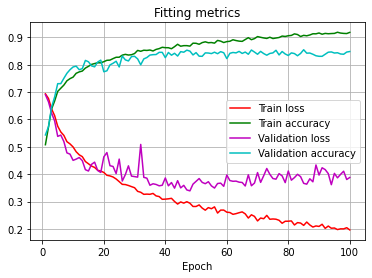

In [20]:
hist = history.history
x = range(1, len(hist['loss']) + 1)

plt.plot(x, hist['loss'], 'r', label='Train loss')
plt.plot(x, hist['accuracy'], 'g', label='Train accuracy')
plt.plot(x, hist['val_loss'], 'm', label='Validation loss')
plt.plot(x, hist['val_accuracy'], 'c', label='Validation accuracy')
plt.title('Fitting metrics')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

З графіку добре видно, що навчання слід закінчити близько 45-50 ітерації, оскільки в подальшому Validation accuracy перестав зростати, а Validation loss почав потроху збільшуватися, що може свідчити про overfitting.

Перевіримо роботу моделі на декількох зображеннях.

В заголовку наведена істинна мітка, розпізнана та впевненість (ймовірність розпізнаної мінус іншої).

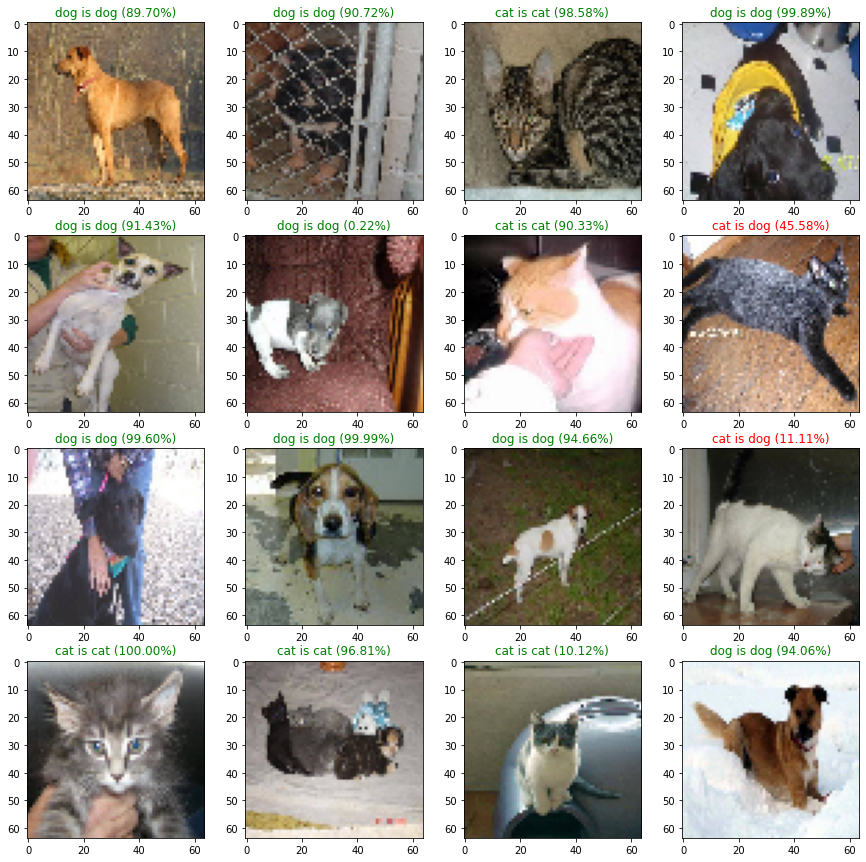

In [104]:
sample = test_data.next()
result = model.predict(sample[0])

fig, axs = plt.subplots(4, 4)
fig.set_size_inches(15,15)

idx = 0
cln = {0: 'cat', 1: 'dog'}

for y in range(0, 4):
    for x in range(0, 4):
        ax = axs[x,y]
        real = round(sample[1][idx])
        pred = np.argmax(result[idx])
        cert = result[idx][pred] - result[idx][1 - pred]
        ax.set_title('%s is %s (%.2f%%)' % (cln[real], cln[pred], 100*cert), {'color': 'r' if real != pred else 'g'})
        ax.imshow(sample[0][idx])
        idx += 1

# Part 3: Text classification (recurrent NN)
Вирішіть одну з трьох задач за вашим вибором: **класифікації текстів**, ~~класифікації часових рядів
або прогнозування значень часового ряду~~ за допомогою рекурентної нейромережі. *тексти можна обирати ті ж самі, що і в лабораторній No 3.*

In [56]:
nltk.download('brown', quiet=True) and nltk.download('stopwords', quiet=True)

True

Розглядаю категорії adventure, mystery та romance.

In [57]:
stop_words = stopwords.words('english')
for punct in ["''", "``", "--"]:
    stop_words.append(punct)

cat_map = {0: 'adventure', 1: 'mystery', 2: 'romance'}
rev_map = {v:k for k,v in cat_map.items()}

paragraphs = {
    cat_id: [[[w.lower() for w in sents if w.lower() not in stop_words and len(w) >= 2]
              for sents in p] for p in brown.paras(categories=cat_value)]
    for cat_id, cat_value in cat_map.items()
}

long_paras = {
    cat_id: [list(itertools.chain.from_iterable(a)) for a in paragraphs[cat_id]]
    for cat_id, cat_value in cat_map.items()
}

In [121]:
texts = []
labels = []
cat_texts = {0:[], 1:[], 2:[]}

for cat_id in cat_map:
    for para in paragraphs[cat_id]:
        sent_str = []
        for sent in para:
            sent_str.append(' '.join(sent))
        string = ' '.join(sent_str)
        texts.append(string)
        cat_texts[cat_id].append(string)
        labels.append(cat_id)

train_texts, test_texts, train_labels, test_labels = \
    train_test_split(texts, labels, test_size=0.3, random_state=2021_12_27)

cats_train = to_categorical(train_labels)
cats_test = to_categorical(test_labels)

tok = Tokenizer(num_words=8000)
tok.fit_on_texts(train_texts)

train_vects = tok.texts_to_matrix(train_texts, mode='count')
test_vects = tok.texts_to_matrix(test_texts, mode='count')

In [146]:
model = Sequential()
model.add(Dense(100, activation="relu", input_shape=(8000,)))
model.add(Dropout(0.4))
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(3, activation = 'softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [130]:
history = model.fit(train_vects, cats_train, epochs=5, batch_size=32, validation_data=(test_vects, cats_test))

Epoch 1/5
84/84 [==============================] - 1s 10ms/step - loss: 1.1743 - accuracy: 0.3824 - val_loss: 1.0889 - val_accuracy: 0.3897
Epoch 2/5
84/84 [==============================] - 1s 7ms/step - loss: 0.8884 - accuracy: 0.5950 - val_loss: 1.0123 - val_accuracy: 0.5210
Epoch 3/5
84/84 [==============================] - 1s 7ms/step - loss: 0.5859 - accuracy: 0.7765 - val_loss: 0.8345 - val_accuracy: 0.6778
Epoch 4/5
84/84 [==============================] - 1s 7ms/step - loss: 0.3692 - accuracy: 0.8651 - val_loss: 0.7297 - val_accuracy: 0.6926
Epoch 5/5
84/84 [==============================] - 1s 7ms/step - loss: 0.2793 - accuracy: 0.9008 - val_loss: 0.7144 - val_accuracy: 0.7032


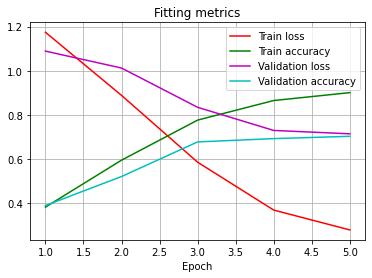

In [131]:
hist = history.history
x = range(1, len(hist['loss']) + 1)

plt.plot(x, hist['loss'], 'r', label='Train loss')
plt.plot(x, hist['accuracy'], 'g', label='Train accuracy')
plt.plot(x, hist['val_loss'], 'm', label='Validation loss')
plt.plot(x, hist['val_accuracy'], 'c', label='Validation accuracy')
plt.title('Fitting metrics')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

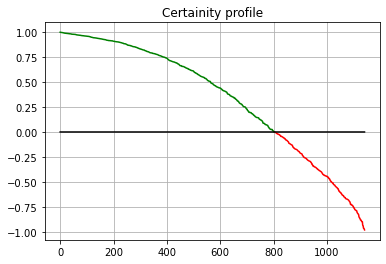

Correct prediction in 803 / 1142 samples


In [145]:
pred_X = model.predict(test_vects)
pred_cls = []
test_cls = []

x = range(0, len(pred_X))
prob_delt = []
cls_dist = []
good_cnt = 0
for i in x:
    pred = pred_X[i]
    test = cats_test[i]
    pred_cls.append(np.argmax(pred))
    test_cls.append(np.argmax(test))
    prob = np.max(pred * test)
    badp = np.max(pred * (1 - test))
    prob_delt.append(prob - badp)
    if prob - badp > 0:
        good_cnt += 1
    else:
        cls_dist.append(abs(np.argmax(test) - np.argmax(pred * (1 - test))))

prob_delt.sort(reverse=True)

plt.plot(x, [(i if i < 0 else np.nan) for i in prob_delt], 'r')
plt.plot(x, [(i if i >= 0 else np.nan) for i in prob_delt], 'g')
plt.plot(x, np.zeros(len(x)), 'k')
plt.title('Certainity profile')
plt.grid()
plt.show()

print('Correct prediction in ' + str(good_cnt) + ' / ' + str(len(pred_X)) + ' samples')